In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import json
import rdkit
from rdkit import Chem
from rdkit.Chem import Draw, BRICS
from krxns.cheminfo import expand_unpaired_cofactors, mcs, draw_molecule, draw_reaction
from krxns.config import filepaths
from krxns.rxn_cxn import SimilarityConnector, extract_compounds
import ipywidgets as widgets
from ipywidgets import interact
import matplotlib.pyplot as plt
from IPython.display import display, SVG
from itertools import product
from collections import defaultdict

In [23]:
# Load known reaction data
with open(filepaths['data'] / 'sprhea_240310_v3_mapped.json', 'r') as f:
    known_reactions = json.load(f)

known_reactions = {int(k): v for k,v in known_reactions.items()}

# Remove reverses
rids = set()
for k, v in known_reactions.items():
    rids.add(tuple(sorted([k, v['reverse']])))

keepers = [elt[0] for elt in rids]
known_reactions = {k: known_reactions[k] for k in keepers}

known_compounds, smi2id = extract_compounds(known_reactions)

# Load op connected reactions
with open(filepaths['connected_reactions'] / 'sprhea_240310_v3_mapped_operator.json', 'r') as f:
    tmp = json.load(f)

op_cxn = {}
for rid, rule_dict in tmp.items():
    op_cxn[int(rid)] = {}
    for rule, side_dict in rule_dict.items():
        op_cxn[int(rid)][rule] = {}
        for side, outer_dict in side_dict.items():
            op_cxn[int(rid)][rule][side] = {}
            for outer_key, inner_dict in outer_dict.items():
                op_cxn[int(rid)][rule][side][int(outer_key)] = {}
                for inner_key, mass in inner_dict.items():
                    op_cxn[int(rid)][rule][side][int(outer_key)][int(inner_key)] = mass

# Load sim connected reactions
with open(filepaths['connected_reactions'] / 'sprhea_240310_v3_mapped_similarity.json', 'r') as f:
    tmp = json.load(f)

sim_cxn = {}
for rid, side_dict in tmp.items():
    sim_cxn[int(rid)] = {}
    for side, outer_dict in side_dict.items():
        sim_cxn[int(rid)][side] = {}
        for outer_key, inner_dict in outer_dict.items():
            sim_cxn[int(rid)][side][int(outer_key)] = {}
            for inner_key, mass in inner_dict.items():
                sim_cxn[int(rid)][side][int(outer_key)][int(inner_key)] = mass

with open(filepaths['connected_reactions'] / 'sprhea_240310_v3_mapped_side_counts.json', 'r') as f:
    side_counts = json.load(f)

side_counts = {int(k): v for k, v in side_counts.items()}

del tmp

Spot check operator connected reactions

In [30]:
ocd_options = list(op_cxn.keys())
op_cxn_dropdown = widgets.Dropdown(options=ocd_options, value=ocd_options[0])

def show_op_cxn(rid):
    for rule in op_cxn[rid]:
        print(f"Rule: {rule}")
        print(f"Rct inlinks: {op_cxn[rid][rule]['rct_inlinks']}")
        print(f"Pdt inlinks: {op_cxn[rid][rule]['pdt_inlinks']}")
        display(SVG(draw_reaction(known_reactions[rid]['smarts'], sub_img_size=(300, 200))))

_ = interact(show_op_cxn, rid=op_cxn_dropdown)

interactive(children=(Dropdown(description='rid', options=(1123, 6566, 2415, 2716, 17163, 9293, 10373, 8841, 1…

In [34]:
scd_options = list(sim_cxn.keys())
sim_cxn_dropdown = widgets.Dropdown(options=scd_options, value=scd_options[0])

def show_sim_cxn(rid):
    translate = lambda x : {known_compounds[outer]['name']: {known_compounds[inner]['name']: inner_v  for inner, inner_v in outer_v.items()} for outer, outer_v in x.items()}
    rct_inlinks = translate(sim_cxn[rid]['rct_inlinks'])
    pdt_inlinks = translate(sim_cxn[rid]['pdt_inlinks'])
    print("Rct inlinks")
    for k, v in rct_inlinks.items():
        print(k, v)
    print("\nPdt inlinks")
    for k, v in pdt_inlinks.items():
        print(k, v)
    display(SVG(draw_reaction(known_reactions[rid]['smarts'], sub_img_size=(300, 200))))

_ = interact(show_sim_cxn, rid=sim_cxn_dropdown)

interactive(children=(Dropdown(description='rid', options=(1123, 740, 7946, 10239, 12221, 13772, 6566, 14312, …

Look at multiply mapped reactions

In [37]:
multiple_imt = {k: v for k, v in op_cxn.items() if len(v) > 1}
print(len(multiple_imt))
mimt_opts = sorted(multiple_imt.keys())
mimt_dropdown = widgets.Dropdown(options=mimt_opts, value=mimt_opts[0])

_ = interact(show_sim_cxn, rid=mimt_dropdown)

246


interactive(children=(Dropdown(description='rid', options=(9, 59, 368, 425, 489, 746, 749, 838, 943, 990, 1199…

In [44]:
trivial_cases = [
    (1, 1),
    (1, 2),
    (1, 3),
    (1, 4)

]

mimt_w_trivial = [k for k in multiple_imt if tuple(side_counts[k]) in trivial_cases]
print(len(mimt_w_trivial))

216


In [43]:
sim_only = {k: v for k, v in sim_cxn.items() if tuple(side_counts[k]) == (2, 2) and k not in op_cxn}
print(len(sim_only))
sim_only_opts = sorted(sim_only.keys())
sim_only_dropdown = widgets.Dropdown(options=sim_only_opts, value=sim_only_opts[0])

_ = interact(show_sim_cxn, rid=sim_only_dropdown)

560


interactive(children=(Dropdown(description='rid', options=(2, 8, 26, 44, 80, 88, 107, 110, 113, 125, 138, 155,…

Histogram of number of reactants / product for reactions I could not map

In [5]:

def filter_cofactors(known_reactions: dict[str, dict], cofactors: dict[str, str], smi2id: dict[str, int], paired_cofactors: dict[tuple, float] = {}):
    '''
    Filters cofactors out of known reaction dict
    '''
    paired_cofactors = {tuple(sorted(k)): v for k, v in paired_cofactors.items()}

    filtered_krs = {}
    for rid, rxn in known_reactions.items():
        lhs, rhs = [set(side.split(".")) for side in rxn['smarts'].split(">>")] # Set out stoichiometric degeneracy
        lhs = [smi2id[elt] for elt in lhs if elt not in cofactors]
        rhs = [smi2id[elt] for elt in rhs if elt not in cofactors]

        if not lhs or not rhs:
            continue

        to_remove = tuple()
        best_jaccard = 0
        for pair in product(lhs, rhs):
            srt_pair = tuple(sorted(pair))

            if srt_pair in paired_cofactors and paired_cofactors[srt_pair] > best_jaccard:
                to_remove = pair # Note NOT srt pair
                best_jaccard = paired_cofactors[srt_pair]

        if to_remove:
            lhs.remove(to_remove[0])
            rhs.remove(to_remove[1])

        if len(lhs) > len(rhs):
            tmp = lhs
            lhs = rhs
            rhs = tmp

        filtered_krs[rid] = (lhs, rhs)
    
    return filtered_krs

def plot_side_counts(side_counts: dict[tuple, set]):
    x_labels, cts = zip(*sorted([(k, len(v)) for k,v in side_counts.items()], key= lambda x : x[1], reverse=True))
    x = np.arange(len(x_labels))

    fig, ax = plt.subplots()
    ax.bar(x, height=cts)
    ax.set_xticks(x)
    ax.set_xticklabels(x_labels, rotation=45)
    ax.set_ylabel("# reactions")
    ax.set_xlabel("(# reactants, # products)")
    plt.show()

    return fig

In [6]:
# Compare with similarity connector

# Load unpaired cofs
unpaired_fp = filepaths['cofactors'] / "unpaired_cofactors_reference.tsv"
name_blacklist = [
    'acetyl-CoA',
    'CoA'
]

unpaired_ref = pd.read_csv(
    filepath_or_buffer=unpaired_fp,
    sep='\t'
)

filtered_unpaired = unpaired_ref.loc[~unpaired_ref['Name'].isin(name_blacklist), :]
cofactors = expand_unpaired_cofactors(filtered_unpaired, k=k)

manual = {
    'N#N': 'N2',
    '[H][H]': 'H2',
    'S': 'hydrogen sufide',
    '[Cl-]': 'chloride',
    '[Na+]': 'sodium'
}

cofactors = {**cofactors, ** manual}

# Load cc sim mats
cc_sim_mats = {
    'mcs': np.load(filepaths['sim_mats'] / "mcs.npy"),
    'tanimoto': np.load(filepaths['sim_mats'] / "tanimoto.npy")
}

[15:16:55] WARNING: not removing hydrogen atom without neighbors


/home/stef/krxns/krxns/rxn_cxn.py:117: RuntimeWarning: invalid value encountered in divide
  cpd_corr = np.where((row_sum + col_sum - cpd_corr) != 0, cpd_corr / (row_sum + col_sum - cpd_corr), 0) # Jaccard co-occurence-in-rxn index. Symmetric


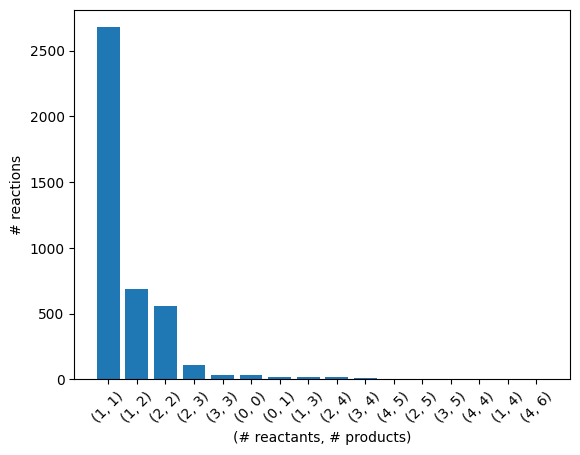

In [7]:
sc = SimilarityConnector(
    reactions=known_reactions,
    cc_sim_mats=cc_sim_mats,
    cofactors=cofactors,
    k_paired_cofactors=21,
)
smi2id = sc.smi2id
paired_cofactors = {pair: sc.cc_sim_mats['jaccard'][pair] for pair in sc.paired_cofactors}
missed_by_op = {k: v for k, v in known_reactions.items() if k not in op_cxn}

filtered_krs = filter_cofactors(missed_by_op, cofactors, smi2id, paired_cofactors)
side_counts = defaultdict(set)
for rid, (lhs, rhs) in filtered_krs.items():
    side_counts[tuple(sorted([len(x) for x in [lhs, rhs]]))].add(rid)

len(op_cxn)
new = plot_side_counts(side_counts)

In [8]:
9300 / 9800

0.9489795918367347